<h1> <font color=steelblue>Constraining Remotely-Sensed River Discharge Estimation Using Reach-Scale Geomorphology</font></h1>
<br>
    Craig Brinkerhoff <br>
    Colin Gleason <br>
    Peirong Lin <br>
    Konstantinos Andreadis <br>
    Mark Hagemann

<h3><font color=darkcyan> What? </font></h3>
<h5>
    Can we produce better discharge estimates by incorporating river physics and 'types' of river physics into BAM?
</h5>
    <br><br>
    1) Introduce more physically-representative river physics into BAM likelihood function <b>DONE</b><br>
        &nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp; 1.5) Is a physically-based manning-amhg switch better than the previously defined mathmatical one? <b>DONE </b><br>
        &nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp; 1.75) Space-varying and Space/Time-varying Manning's n yielding improvement?? <b>DONE </b><br><br>
    2) Introduce priors that are trained on a larger, more physically-representative training set of hydraulics measurements <b> DONE </b><br>
    3) Constrain old and new priors by river type via a river classification framework built on training set <b>ONGOING </b> <br>
   &nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;  1) test class-binned Wb, Db, and A0 <b>DONE-doing moving forward</b><br>
      &nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;  2) test more/less classes <b>DONE- 8 is most I can do before notable class overlap (also best result...)</b><br>
            &nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;  3) Extrapolate to wide rivers <b>DONE</b><br>
    <br>
    4) Machine Learning Approaches <br>
    &nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;  1) straight k-means on training data and mapped to pepsi using river width <b>DONE- worse </b><br>
    &nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;  2) DBSCAN <b>Ongoing </b><br>

<h3><font color=darkcyan> USGS NHD 2.1 </font></h3>

<p> This work is performed on a dataset of USGS field mesurements of channel hydraulics originally collected by Barber and Gleason (2018) joined to NHD, resulting in an expanded version of the dataset used in Brinkerhoff, et al. (2019)
    <br><br>
    Stream Order <br>
    Slope <br>
    Distance Downstream <br>
    Maximum Grain Size Entrained (Henderson, 1966) <br>
    Shear Stress <br>
    Froude Number <br>
    Drainage Area <br>
    Unit Stream Power <br>
    Channel Shape <br>
    Channel Width <br>
    Channel Depth <br>
    Channel Velocity <br>
    Bankfull Shape <br>
    Bankfull Width <br>
    Bankfull Depth <br>
    Bankfull Velocity <br>
    Reach Type (i.e. perennial, intermittent, lake/wetland/reservoir, canal, or connector).<br>
    Sinuosity
    <br><br>It must be stressed that these joined variables exist at the reach-scale, while the field measurements exist at the cross-section scale. Also, these results are only reflective of the hydrology/geomorphology of river reaches measured by the USGS, generally at streamagauges.</p>

<h3><font color=darkcyan> Lakes/Reservoirs Preprocessing on NHD </font></h3>
<p> NHD for some reason has assigned many main stem or close-to-main stem reaches as artifical paths and not rivers.  Artifical paths are only supposed to be for throughflow lines in lakes/wetlands/reservoirs.
<br><br>
So, I identified reaches classed as 'ArtificalPath' that had no corresponding waterbodyID in the lakes dataset, assumed main stem reaches are perrenial, and reclassified those reaches as perrenial rivers.
<br><br> Canals and NHD's 'connectors' are listed as Artifical Channels.  'Connectors' are reaches the NHD had to add to make the network continuous in some places (i.e. through dams)
<br><br>
I am using the NHD's defintion of river intermittncy.  It's unclear how they designate perrenial/intermittent/ephemeral (no ephemeral reaches had measurements on them)
</p>

<h3><font color=darkcyan> Functions </font></h3>

In [3]:
#AHG exp function
def regress(data, yvar, xvars):
    Y = np.log(data[yvar])
    X = np.log(data[xvars])
    X['intercept'] = 1.
    result = sm.OLS(Y, X).fit()
    return result.params[0] #only get exp

#AHG int function
def regress2(data, yvar, xvars):
    Y = np.log(data[yvar])
    X = np.log(data[xvars])
    X['intercept'] = 1.
    result = sm.OLS(Y, X).fit()
    return result.params[1] #only get int

#bankfull hydraulics function
def calculate_bankful(df, colname, retPeriod):
    # sort data smallest to largest
    sorted_data = df.sort_values(by=colname, ascending = False)
    # count total obervations
    n = sorted_data.shape[0]
    # add a numbered column 1 -> n to use in return calculation for rank
    sorted_data.insert(0, 'rank', range(1, 1 + n))
    #find desired rank
    desiredRank = (n+1)/retPeriod
    desiredRank = round(desiredRank)
    #get variable with desired rank
    output = sorted_data.loc[sorted_data['rank'] == desiredRank, colname]
    return(output)

#AHG r2 function
def regress3(data, yvar, xvars):
    Y = np.log(data[yvar])
    X = np.log(data[xvars])
    X['intercept'] = 1.
    result = sm.OLS(Y, X).fit()
    return result.rsquared #only get r2

<h3><font color=darkcyan> Data Wranglin' & Cleanin' </font></h3>

In [4]:
import pandas as pd
import os
import numpy as np
import scipy.stats.mstats as sp
import matplotlib.pyplot as plt
import seaborn as sns
import statsmodels.api as sm
import math
from IPython.display import display, HTML
from sklearn.cluster import KMeans
from sklearn import metrics
from sklearn import svm
from sklearn.preprocessing import StandardScaler
from sklearn.decomposition import PCA
from sklearn import linear_model
from pandas.plotting import scatter_matrix
from sklearn.metrics import confusion_matrix, accuracy_score
from sklearn.model_selection import train_test_split
from sklearn.metrics import mean_squared_error
from math import sqrt
from bokeh.plotting import figure, show, output_notebook
from bokeh.tile_providers import CARTODBPOSITRON
from ast import literal_eval

#set working directory
os.chdir("C:\\Users\\cbrinkerhoff\\Box Sync\\Ongoing Projects\\geomorph_class\\")

#load in barber dataset
Hydroshortened = pd.read_csv('Barber_rivers.csv', low_memory=False, encoding='latin-1')

#NHD 2.1 flowlines (with USGS gauges snapped to them) and lakes
med_NHD = pd.read_csv('NHD_med_res.csv', low_memory=False, encoding='latin-1')
med_NHD_lakes = pd.read_csv('med_NHD_lakes.csv', low_memory=False, encoding='latin-1')

#NHD sinuosity from  Wieczorek, M.E., Jackson, S.E., and Schwarz, G.E., 2018, Select Attributes for NHDPlus Version 2.1 Reach Catchments and Modified Network Routed Upstream Watersheds for the Conterminous United States: U.S. Geological Survey data release, https://doi.org/10.5066/F7765D7V. 
sinuosityCONUS = pd.read_csv('Sinuousity_CONUS.txt', delimiter=',')

Hydroshortened = pd.merge(Hydroshortened, med_NHD[['SOURCE_FEA', 'COMID', 'SLOPE', 'StreamOrde', 'ArbolateSu', 'Measure', 'LENGTHKM', 'LatSite', 'LonSite', 'FTYPE', 'FCODE', 'DASqKm', 'Tidal', 'WBAREACOMI', 'TOTMA']],left_on='site_no', right_on='SOURCE_FEA')
Hydroshortened = pd.merge(Hydroshortened, sinuosityCONUS, left_on='COMID', right_on='COMID')

<h4> <font color=darkolivegreen>Filter sites w/ impossible AHG</font> </h4>

<h4> <font color=darkolivegreen>Width AMHG</font> </h4>

<h4> <font color=darkolivegreen>Resulting Dataset Size and Spatial Distribution</font> </h4>

In [5]:
print('\033[1m' + "# measurements:")
display(len(Hydroshortened.index))

print('\033[1m' + "# cross-sections:")

display(Hydroshortened.groupby('site_no').ngroups)

print('\033[1m' + "# rivers:")
display(Hydroshortened.groupby('river_name').ngroups)

Hydroshortened.to_csv('for_dbscan.csv')

# measurements:


717138

# cross-sections:


1772

# rivers:


190

<h3><font color=darkcyan> Calculate Global Priors </font></h3>

<h4> <font color=darkolivegreen>Calculate Global Hat Functions</font> </h4>

<h4> <font color=darkolivegreen>Extract Braided River Prior Information</font> </h4>

<h3><font color=darkcyan> Classifying by River Type </font></h3>

<h4> <font color=darkolivegreen>Supervised: PCA-Based 'Fluvial Index' </font></h4>

<p>
    5 PCs were ultimately selected for analysis as they explain ~75% of variance in the dataset.
</p>
<p>
   The top weighted metrics for PC1 are unit power, slope, shear stress, and minimum entrained grain size.  For PC2 they are stream order, distance downstream, and drainage area.  For PC3 it is velocity and froude number,  for PC4 it is residence time, depth, and waterbody type, and PC5 is channel shape.
    <br><br>
    <b>The main axes of geomorphic variation across these rivers have thus been termed 'Sediment Transport', 'Longitunidal Location', 'Flow State', 'waterbody type', and 'Channel Shape'.</b>
</p>
<br>
<p>
    I then use a 'geomorphic index' which is just a sum of the top 5 PC values for each measurement.  This is purposefully not weighted by the relative importance of each PC (i.e. they're all weighted equally).  Classes are then determined by breaking the measurements along the deciles for the distribution
</p>
<br>
<b>
    This largely amounts to a classification of 'river magnitude'
</b>

<h4><font color=darkolivegreen>Unsupervised: KMeans </font> </h4>
<br><br>
Kmeans sets intial 'cluster means' given clusters n and then iteraively groups points until cluster means are sufficiently different

<h4> <font color=darkolivegreen> DBSCAN Clustering </font></h4>
<br><br>
DBSCAN, unlike KMeans, doesn't assume convex shape for clusters.  Setting a max radius for clusters epislon and a minimum cluster size, it finds clusters amongst noisy points outside the epislon of all clusters

In [30]:
data = pd.read_csv('C:\\Users\\cbrinkerhoff\\Box Sync\\Ongoing Projects\\geomorph_class\\dbscan\\clustered_ep_1.csv', low_memory=False)

data['logA0'] = np.log(data['A0'])
data['logr'] = np.log(data['r'])
data['logn'] = np.log(data['n'])
data['logWb'] = np.log(data['bank_width'])
data['logDb'] = np.log(data['bank_depth'])

#extract class distributions
#maps class to river based on 'closest' median cross-sectional average width of each class
binnedMeanWdths = data.groupby('cluster')['logchan_width'].describe()
binnedMeanWdths.to_csv('WidthsClassDBSCAN_1.csv')

#save prior distribution parameters
priorWbClassDBSCAN = data.groupby('cluster')['logWb'].describe()
priorDbClassDBSCAN = data.groupby('cluster')['logDb'].describe()
prior_rClassDBSCAN = data.groupby('cluster')['logr'].describe()
priorA0ClassDBSCAN = data.groupby('cluster')['logA0'].describe()
priorNClassDBSCAN = data.groupby('cluster')['logn'].describe()
priorBClassDBSCAN = data.groupby('cluster')['b'].describe()

priorWbClassDBSCAN.to_csv('priorsWbClassDBSCAN_1.csv')
priorDbClassDBSCAN.to_csv('priorsDbClassDBSCAN_1.csv')
prior_rClassDBSCAN.to_csv('priorsRClassDBSCAN_1.csv')
priorA0ClassDBSCAN.to_csv('priorsA0ClassDBSCAN_1.csv')
priorNClassDBSCAN.to_csv('priorsNClassDBSCAN_1.csv')
priorBClassDBSCAN.to_csv('priorsBClassDBSCAN_1.csv')

[(-6, -1)]

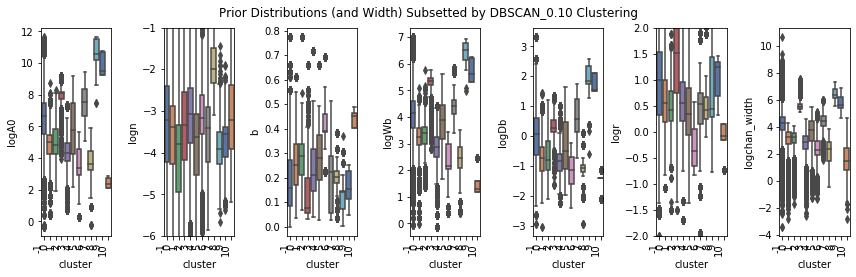

In [31]:
fig, axs = plt.subplots(ncols=7, figsize=(12, 4))
sns.boxplot(x="cluster", y='logA0', data=data, palette='deep', ax=axs[0])
sns.boxplot(x="cluster", y='logn', data=data, palette='deep', ax=axs[1])
sns.boxplot(x="cluster", y='b', data=data, palette='deep', ax=axs[2])
sns.boxplot(x="cluster", y='logWb', data=data, palette='deep', ax=axs[3])
sns.boxplot(x="cluster", y='logDb', data=data, palette='deep', ax=axs[4])
sns.boxplot(x="cluster", y='logr', data=data, palette='deep', ax=axs[5])
sns.boxplot(x="cluster", y='logchan_width', data=data, palette='deep', ax=axs[6])

fig.suptitle("Prior Distributions (and Width) Subsetted by DBSCAN_0.10 Clustering")
fig.autofmt_xdate(rotation=90)
fig.tight_layout(rect=[0, 0.03, 1, 0.95])
axs[5].set(ylim=(-2, 2))
axs[1].set(ylim=(-6, -1))

<h4> <font color=darkolivegreen> Scratch Stuff </font></h4>